### Problem Statement
Stock price prediction is the task of forecasting the future value of a given stock. Given the historical daily close price for S&P 500 Index, prepare and compare forecasting solutions.

S&P 500 or Standard and Poor's 500 index is an index comprising of 500 stocks from different sectors of US economy and is an indicator of US equities. Other such indices are the Dow 30, NIFTY 50, Nikkei 225, etc.

Prophet uses an additive model that can work with trending and seasonal data. The aim of this tool 
is to enable forecasting at scale. We now test how we can use this tool to forecast.

In [1]:
import fbprophet
import pandas as pd
from fbprophet import Prophet

import time
import numpy as np
import pandas as pd
import pandas_datareader as pdr

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler



In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('notebook')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### Define Functions

In [3]:
# get stock price information 
def get_raw_data(index_name,retry_attempts = 6):   
    if index_name:
        while retry_attempts > 0 :
            try:
                df = pdr.get_data_yahoo(index_name)
                new_df = df.reindex(index=pd.date_range(df.index.min(), 
                                          df.index.max(), 
                                          freq='D')).fillna(method='ffill')
                retry_attempts = 0
                return new_df
            except:
                print("Data pull failed. {} retry attempts remaining".\
                      format(retry_attempts))
                retry_attempts = retry_attempts - 1
    else:
        print("Invalid usage. Parameter index_name is required")
    return None
    


## Set Parameters

In [4]:
TRAIN_PERCENT = 0.9
STOCK_INDEX = '^GSPC'

## Getting Data

In [5]:
sp_df = get_raw_data(STOCK_INDEX)

## Preprocessing Data

The model expects the time series value to be in a column named ‘y’ 
and timestamp in column named ‘ds’. 

In [6]:
# reset index to get date_time as a column
prophet_df = sp_df.reset_index()

# prepare the required dataframe
prophet_df.rename(columns={'index':'ds','Close':'y'},inplace=True)
prophet_df = prophet_df[['ds','y']]

In [7]:
# prepare train and test sets
train_size = int(prophet_df.shape[0]*TRAIN_PERCENT)
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size+1:]

## Prepare Prophet Model

In [8]:
# build a prophet model
pro_model = Prophet()

## Fit the Model

In [9]:
# fit the model
pro_model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecast

To make forecasts, prophet requires the set of dates for which we need 
to forecast. For this, it provides a clean utility called the make_future_dataframe(), which takes the number 
of days required for the forecast as input.

In [10]:
# prepare a future dataframe
test_dates = pro_model.make_future_dataframe(periods=test_df.shape[0])

# forecast values
forecast_df = pro_model.predict(test_dates)

## Plot Test Predictions

The output from the predict() function is a dataframe that includes both in-sample predictions as 
well as forecasted values. The dataframe also includes the confidence interval values. All of this can be easily 
plotted using the plot() function of the model object.

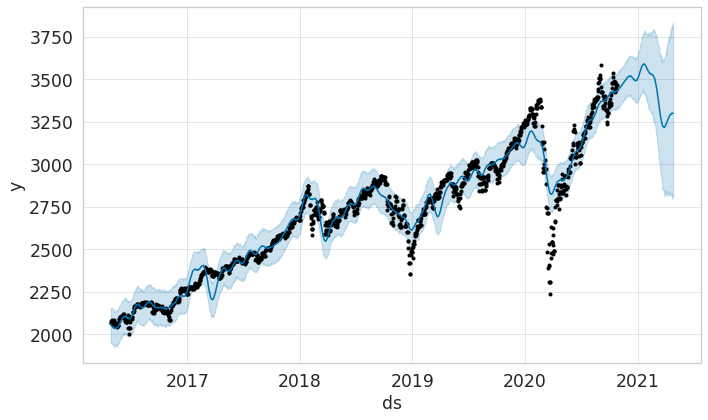

In [11]:
pro_model.plot(forecast_df)
plt.show()

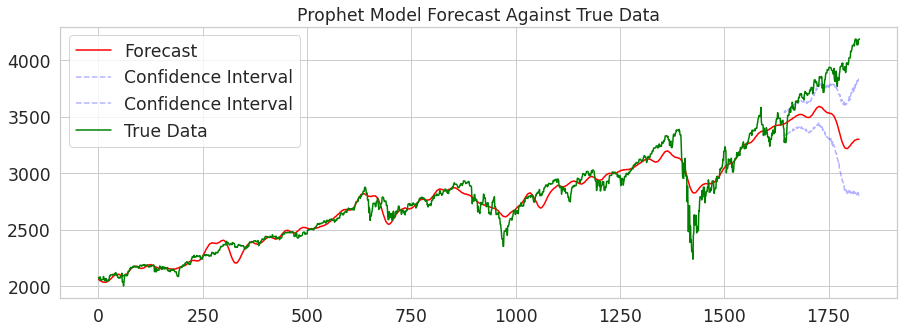

In [12]:
# plot against true data
plt.plot(forecast_df.yhat,c='r',label='Forecast')
plt.plot(forecast_df.yhat_lower.iloc[train_size+1:],
         linestyle='--',c='b',alpha=0.3,
         label='Confidence Interval')
plt.plot(forecast_df.yhat_upper.iloc[train_size+1:],
         linestyle='--',c='b',alpha=0.3,
         label='Confidence Interval')
plt.plot(prophet_df.y,c='g',label='True Data')
plt.legend()
plt.title('Prophet Model Forecast Against True Data')
plt.show()